## 本章来探索时间序列之外的特征

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [4]:
sns.set_theme(style="whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [5]:
main=pd.read_csv('../data/train.csv')
sub=pd.read_csv('../data/store.csv')
sub.head()

/tmp/ipykernel_4333/2652694655.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  main=pd.read_csv('../data/train.csv')


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


store.csv包含了很多关于店铺的信息，将它们合并到主表中

In [6]:
train_data=pd.merge(main,sub,on='Store',how='left')
train_data['Date']=pd.to_datetime(train_data['Date'])
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


先看看商店运行方式

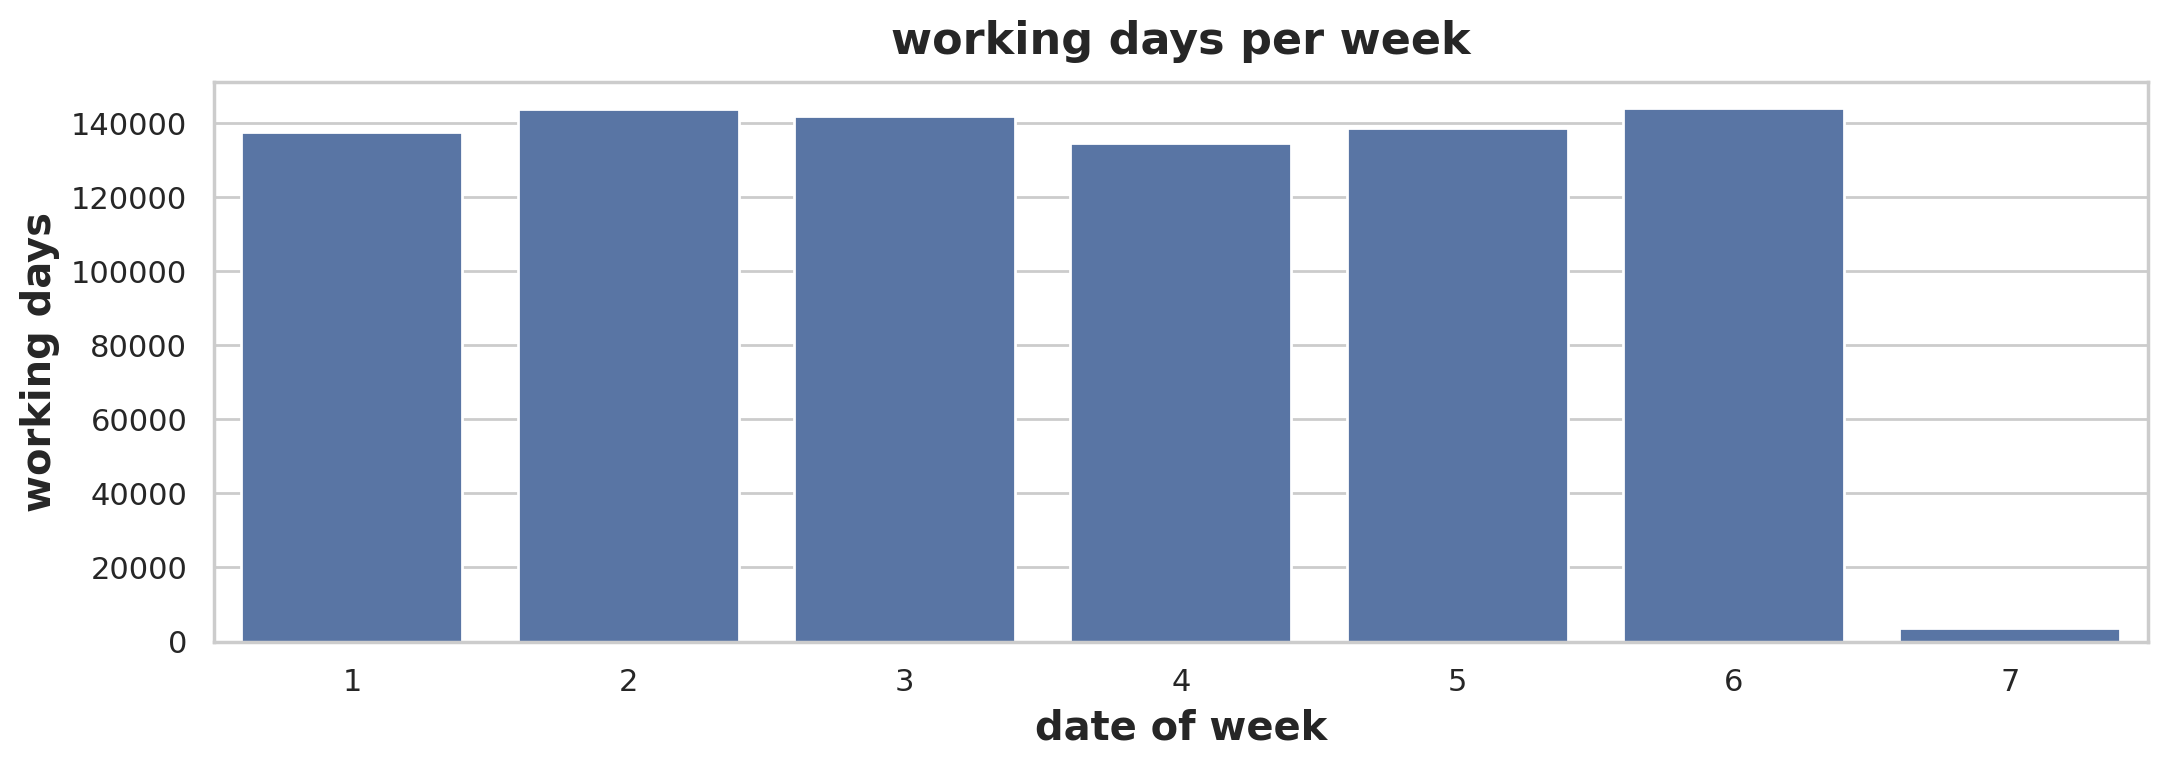

In [7]:
sum_working_days=train_data.groupby(('DayOfWeek'))['Open'].sum()
sns.barplot(x=sum_working_days.index,y=sum_working_days.values)
plt.title('working days per week')
plt.xlabel('date of week')
plt.ylabel('working days')
plt.show()

显然，在常规日期周一到周六营业，周日几乎不营业。接下来看看哪天营业额最高

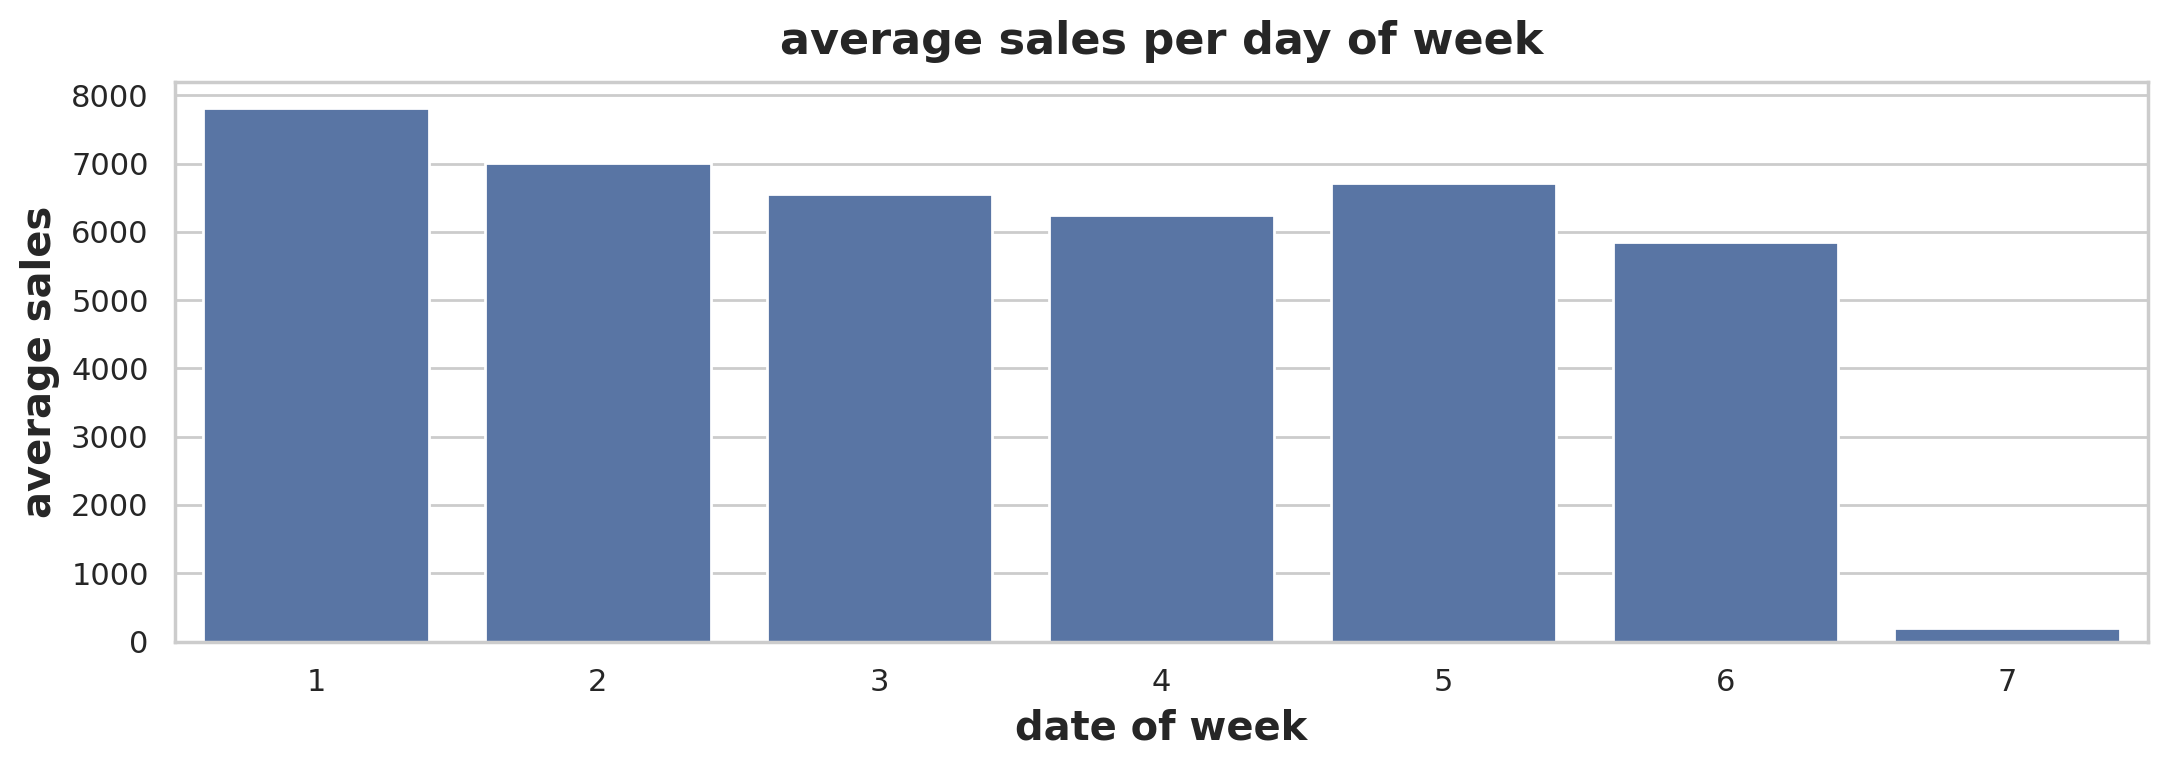

In [8]:
mean_sales=train_data.groupby('DayOfWeek')['Sales'].mean()
sns.barplot(x=mean_sales.index,y=mean_sales.values)
plt.title('average sales per day of week')
plt.xlabel('date of week')
plt.ylabel('average sales')
plt.show()

在正常营业的六天中，从周一到周四营业额不断递减，到周五有所反弹后，周六又有所下降。可以作为一个特征

In [9]:
only_promo2=train_data[(train_data['Promo2']==1)&(train_data['Promo']==1)].copy()
print(f"Number of records with only Promo2 active: {len(only_promo2)}")
only_promo2.head()

Number of records with only Promo2 active: 194016


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


寻找节日有关信息。我们先将每家店每个weeek of day的**基线价格和基线顾客数**创建出来，这样就能方便地分析每一个维度是怎么影响价格的

In [10]:
split_data=train_data[['Date','Store','DayOfWeek','Sales','Customers','Promo']].copy()
split_data.sort_values(by=['Date','Store'],ascending=[True,True],inplace=True)
split_data.set_index('Date',inplace=True)
strandard_data=split_data[split_data['Promo']==0][['Store', 'DayOfWeek', 'Sales', 'Customers']].copy().dropna()
print(f"Number of records without promotion: {len(strandard_data)}")
strandard_data['baseline_sales']=strandard_data.groupby(['Store','DayOfWeek'])['Sales'].transform(lambda x:x.expanding().mean())
strandard_data['baseline_customers']=strandard_data.groupby(['Store','DayOfWeek'])['Customers'].transform(lambda x:x.expanding().mean())
strandard_data.tail()

Number of records without promotion: 629129


,Store,DayOfWeek,Sales,Customers,baseline_sales,baseline_customers
Date,,,,,,
2015-07-26,1111,7,0,0,0.0,0.0
2015-07-26,1112,7,0,0,0.0,0.0
2015-07-26,1113,7,0,0,0.0,0.0
2015-07-26,1114,7,0,0,0.0,0.0
2015-07-26,1115,7,0,0,0.0,0.0


In [11]:
split_data = split_data.reset_index()      # now has column 'Date'
strandard_data = strandard_data.reset_index()
print(split_data.columns)
print(strandard_data.columns)

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo'], dtype='object')
Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'baseline_sales',
       'baseline_customers'],
      dtype='object')


In [12]:
result = pd.merge_asof(
    split_data,
    strandard_data[['Date', 'Store', 'DayOfWeek', 'baseline_sales', 'baseline_customers']],
    by=["Store", "DayOfWeek"],    # 精确匹配
    on="Date",                    # 时间对齐
    direction="backward"        # 向后寻找<=最近的baseline
)

result[(result['Store']==114)&(result['DayOfWeek']==3)].tail(15)

,Date,Store,DayOfWeek,Sales,Customers,Promo,baseline_sales,baseline_customers
904707,2015-04-22,114,3,4684,560,0,4062.859649,507.807018
912512,2015-04-29,114,3,5712,622,1,4062.859649,507.807018
920317,2015-05-06,114,3,6297,622,1,4062.859649,507.807018
928122,2015-05-13,114,3,5549,622,0,4088.482759,509.775862
935927,2015-05-20,114,3,6223,637,1,4088.482759,509.775862
943732,2015-05-27,114,3,4988,585,0,4103.728814,511.050847
951537,2015-06-03,114,3,5408,572,1,4103.728814,511.050847
959342,2015-06-10,114,3,3999,501,0,4101.983333,510.883333
967147,2015-06-17,114,3,5900,601,1,4101.983333,510.883333
974952,2015-06-24,114,3,3929,465,0,4099.147541,510.131148


我们已经将基线数据处理了出来，接下来看看promo=1对销售量有多大影响

In [14]:
promo_day=result[result['Promo']==1].copy()
promo_day['raise_rete']=promo_day['Sales']/promo_day['baseline_sales']-1
promo_day[(promo_day['Store']==114)&(promo_day['DayOfWeek']==3)].tail(15)

,Date,Store,DayOfWeek,Sales,Customers,Promo,baseline_sales,baseline_customers,raise_rete
811047,2015-01-28,114,3,6177,610,1,4031.725490,506.705882,0.532098
818852,2015-02-04,114,3,5670,585,1,4031.725490,506.705882,0.406346
834462,2015-02-18,114,3,5817,622,1,4028.307692,505.884615,0.444031
850072,2015-03-04,114,3,5298,536,1,4043.716981,506.603774,0.310181
865682,2015-03-18,114,3,5146,569,1,4036.074074,506.092593,0.275001
881292,2015-04-01,114,3,7880,803,1,4039.709091,505.909091,0.950636
896902,2015-04-15,114,3,5550,550,1,4051.767857,506.875000,0.369772
912512,2015-04-29,114,3,5712,622,1,4062.859649,507.807018,0.405906
920317,2015-05-06,114,3,6297,622,1,4062.859649,507.807018,0.549894
935927,2015-05-20,114,3,6223,637,1,4088.482759,509.775862,0.522081


我们发现promo会对销售量产生极大的提升，我们选取店120的2014年周三的基线-promoday对比数据将它画出来

Number of records for Store 120 in 2014: 53


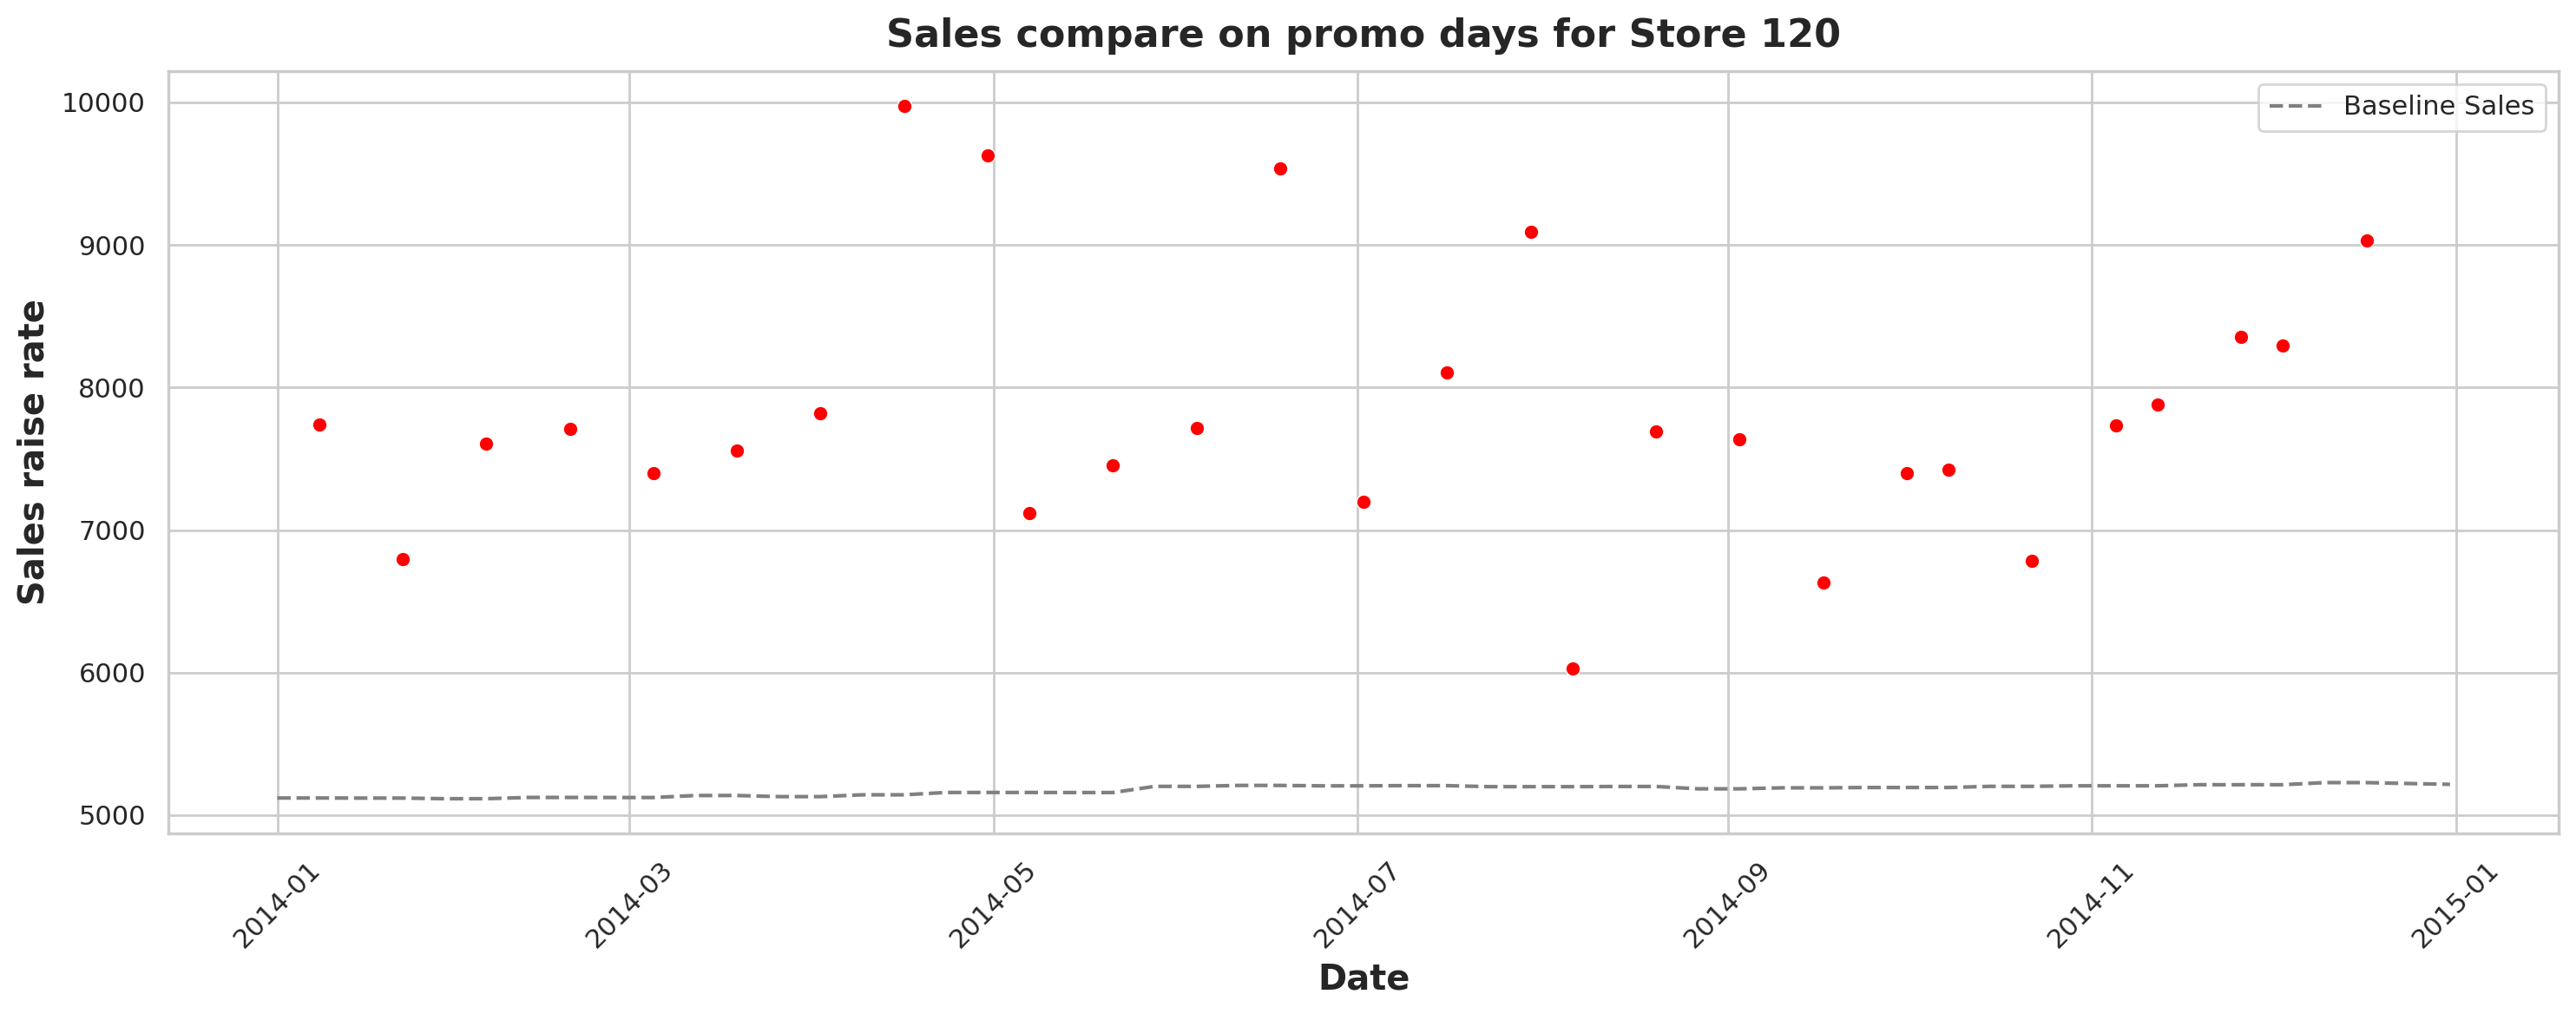

In [22]:
plt.figure(figsize=(15, 6))
store120_data=result[(result['Store']==120)&(result['Date']<'2015-01-01')&(result['Date']>'2013-12-31')&(result['DayOfWeek']==3)].copy()
print(f"Number of records for Store 120 in 2014: {len(store120_data)}")
sns.lineplot(
    data=store120_data, x='Date', y='baseline_sales', color='grey', linestyle='--', label='Baseline Sales'
)
sns.scatterplot(
    data=store120_data[store120_data['Promo']==1], x='Date', y='Sales', color='red')
plt.title('Sales compare on promo days for Store 120')
plt.xlabel('Date')
plt.ylabel('Sales raise rate')
plt.xticks(rotation=45)
plt.show()

这张图直观地说明了promo对销售额的影响有多么客观。但是同时也发现了不同promo日间的提升率方差也很大，这可能是多因素协同造成的。我们将会在下文讨论

## holiday与promo的关系

先来讨论StateHoliday和SchoolHoliday	之间的逻辑关系

In [23]:
holiday=train_data[train_data['Store']==78][['StateHoliday','SchoolHoliday']].copy()
print('StateHoliday的数量',len(holiday[holiday['StateHoliday']!=0]))
print('SchoolHoliday的数量',len(holiday[holiday['SchoolHoliday']!=0]))
print('StateHoliday和SchoolHoliday同时为1的数量',len(holiday[(holiday['StateHoliday']!=0)&(holiday['SchoolHoliday']!=0)]))
print('StateHoliday为1的数量且SchoolHoliday为0的数量',len(holiday[(holiday['StateHoliday']!=0)&(holiday['SchoolHoliday']==0)]))
print('StateHoliday为0的数量且SchoolHoliday为1的数量',len(holiday[(holiday['StateHoliday']==0)&(holiday['SchoolHoliday']!=0)]))

StateHoliday的数量 813
SchoolHoliday的数量 168
StateHoliday和SchoolHoliday同时为1的数量 127
StateHoliday为1的数量且SchoolHoliday为0的数量 686
StateHoliday为0的数量且SchoolHoliday为1的数量 41


我们发现StateHoliday和SchoolHoliday之间的交叉关系非常一般，大部分stateholiday和schoolholiday不是同时为1的，这说明对于78号店这两者很可能是独立的对店面影响的因素而不是同一个概念下的假期。我们会通过Cramer’s v来量化两者关系

/tmp/ipykernel_4333/2367470803.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cramers_v_per_store=train_data.groupby('Store').apply(lambda x: cramers_v(x['StateHoliday'], x['SchoolHoliday']))


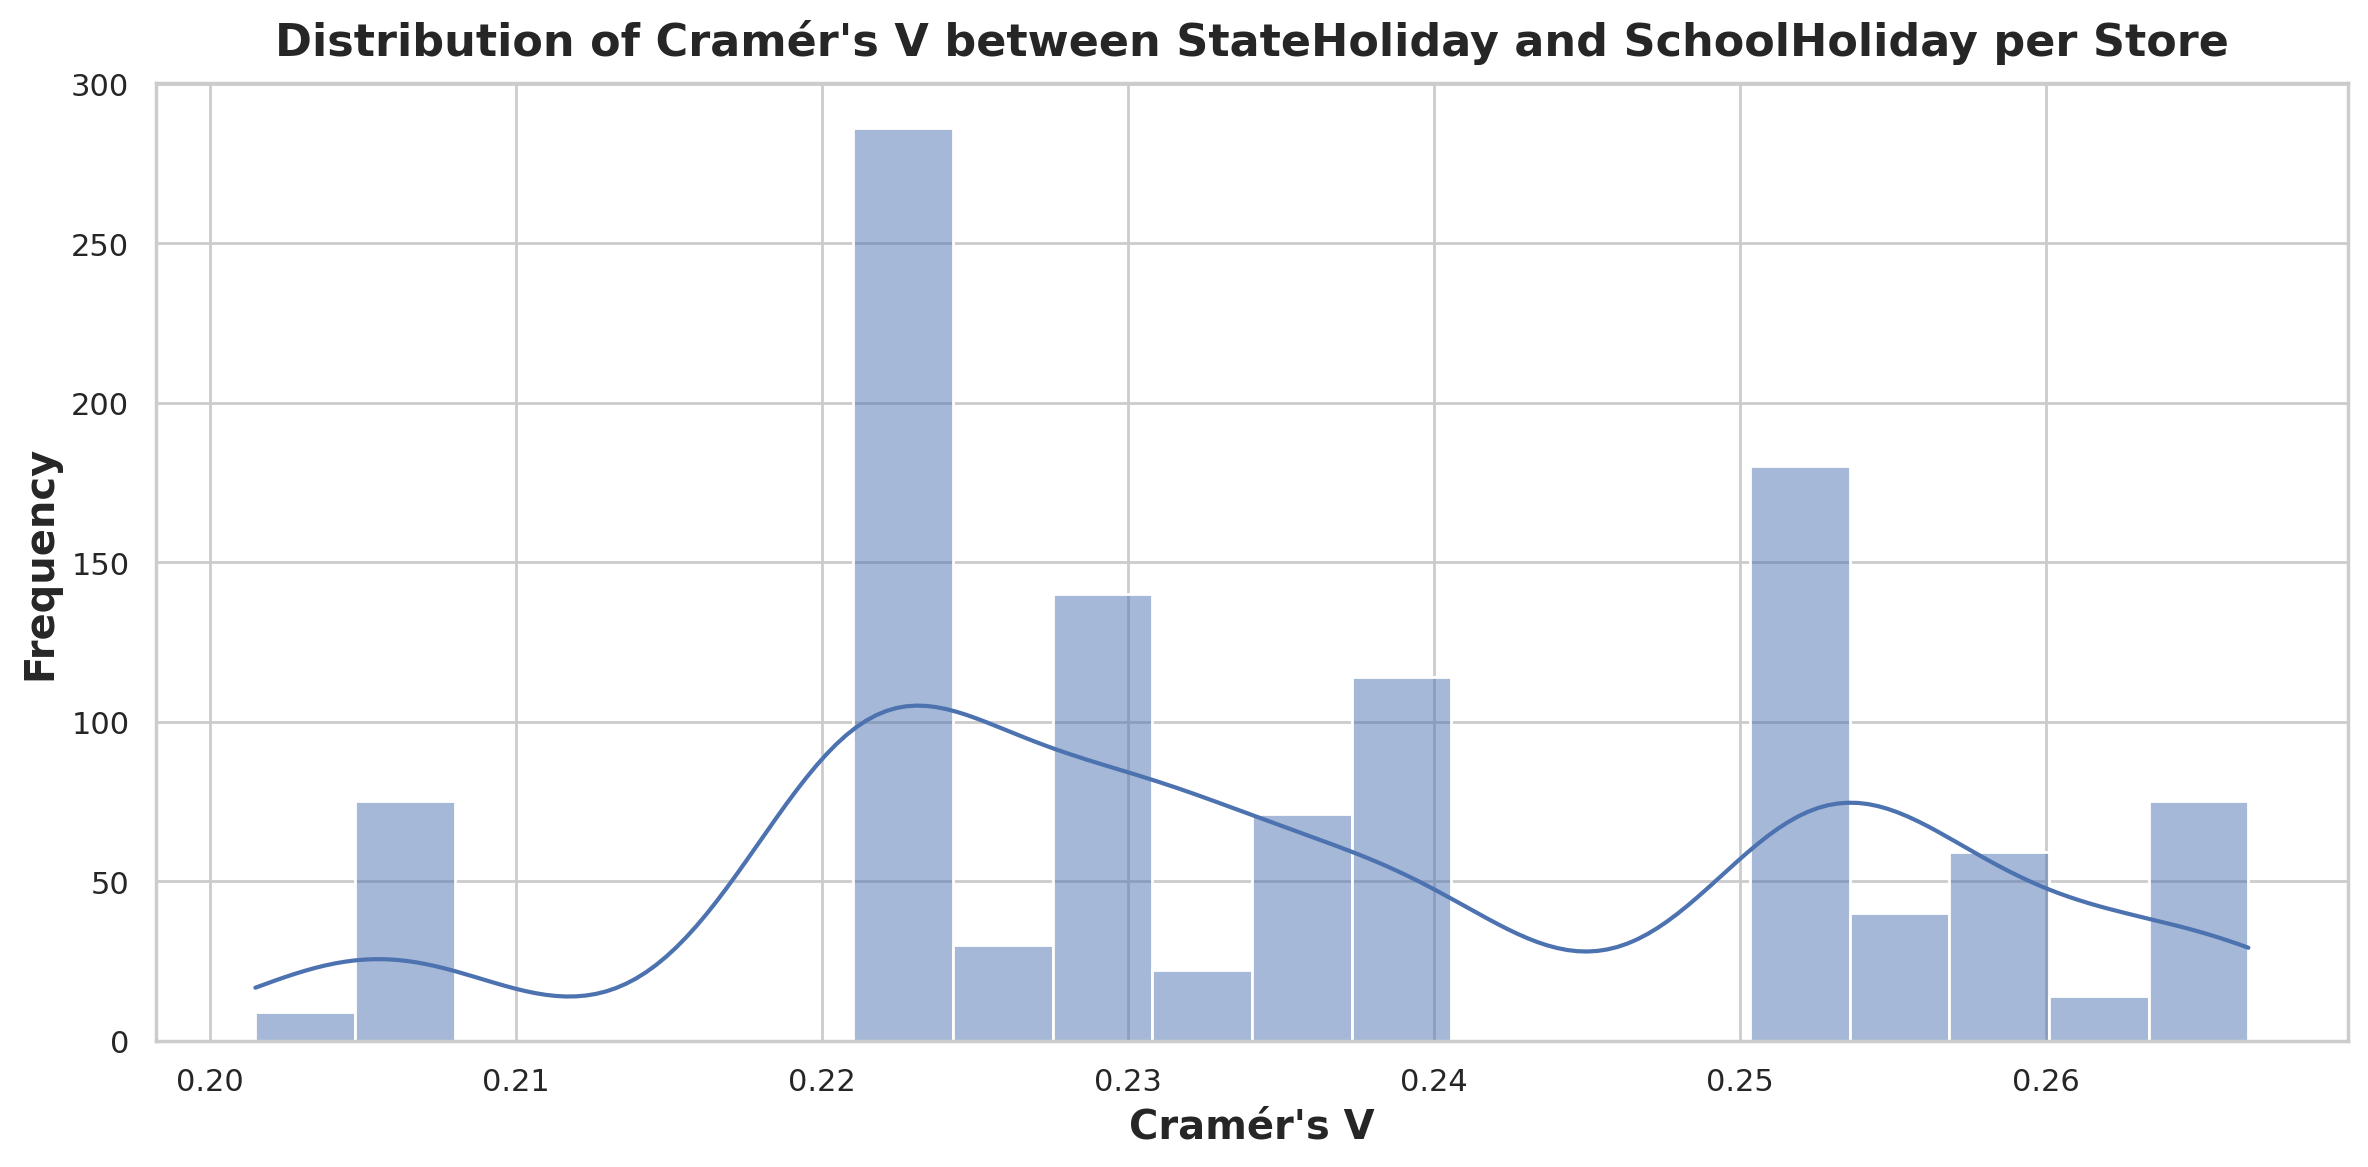

In [ ]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))
cramers_v_per_store=train_data.groupby('Store').apply(lambda x: cramers_v(x['StateHoliday'], x['SchoolHoliday']))
cramers_v_per_store.describe()
plt.figure(figsize=(12, 6))
sns.histplot(cramers_v_per_store, bins=20, kde=True)
plt.title("Distribution of Cramér's V between StateHoliday and SchoolHoliday per Store")
plt.xlabel("Cramér's V")
plt.ylabel("Frequency")
plt.show()

In [26]:
print('max_cramers_v:',cramers_v_per_store.max())

max_cramers_v: 0.26661493112502893


**结论**：我们发现 StateHoliday 与 SchoolHoliday 在每家店之间几乎相互独立（Cramer's V ~0.22）。这意味着两者代表不同类型的假期行为模式：StateHoliday 反映全国或州层面的法定假日，而 SchoolHoliday 更多表示学校长期放假对特定类型门店的额外影响。因此在后续建模中，有必要将 holiday 类型拆开处理，而非合并成单一指标。

### holiday-baseline_sale关系及holiday-promo交互

In [27]:
print('节日期间不放假的次数:',len(train_data[(train_data['StateHoliday']==1)& (train_data['Open']==1)]))

节日期间不放假的次数: 0


看得出来这是一家遵守当地劳动法的企业，如果我们要分析holiday与promo的关系，则必须从假期前后几天来看相关性。我们设计一个假期前后窗口特征：我们选取假期前后k个有效窗口，看看在这些窗口中promo出现的频率是否会高于基线

In [38]:
# 只留下关门 & 非假期当天的数据
split2 = train_data[['Date','Store','DayOfWeek','Sales','Promo','StateHoliday','SchoolHoliday','Open']].copy()
split2 = split2[(split2['Open'] == 1) & (split2['StateHoliday'] == '0')]

# baseline: 每家店促销浓度
split2['promo_rate_baseline'] = split2.groupby('Store')['Promo'].transform('mean')

# 找出所有 state holiday 的日期（不去除 open，因为我们需要事件日本身）
holidays = (
    train_data.loc[train_data['StateHoliday'] != 0, ['Store','Date']]
    .drop_duplicates()
)
print(holidays.head())
# 设置窗口范围：假期前后 k 天
k =6
lag = pd.DataFrame({'rel_day': range(0,k)})
# 笛卡尔积，将每个 holiday 连接 rel_day，生成 target_date
holiday_win = holidays.merge(lag, how="cross")
holiday_win['lag_date'] = holiday_win['Date'] - pd.to_timedelta(holiday_win['rel_day'], unit='D')
holiday_win['lead_date'] = holiday_win['Date'] + pd.to_timedelta(holiday_win['rel_day'] , unit='D')
holiday_win.head(15)


   Store       Date
0      1 2015-07-31
1      2 2015-07-31
2      3 2015-07-31
3      4 2015-07-31
4      5 2015-07-31


,Store,Date,rel_day,lag_date,lead_date
0,1,2015-07-31,0,2015-07-31,2015-07-31
1,1,2015-07-31,1,2015-07-30,2015-08-01
2,1,2015-07-31,2,2015-07-29,2015-08-02
3,1,2015-07-31,3,2015-07-28,2015-08-03
4,1,2015-07-31,4,2015-07-27,2015-08-04
5,1,2015-07-31,5,2015-07-26,2015-08-05
6,2,2015-07-31,0,2015-07-31,2015-07-31
7,2,2015-07-31,1,2015-07-30,2015-08-01
8,2,2015-07-31,2,2015-07-29,2015-08-02
9,2,2015-07-31,3,2015-07-28,2015-08-03


In [ ]:
holiday_win['lag_day']=holiday_win['rel_day']*(-1)
split2=split2.merge(
    holiday_win[['Store','lag_date','lag_day']],left_on=['Store','Date'],right_on=['Store','lag_date'],how='left'
)
split2=split2.merge(
    holiday_win[['Store','lead_date','rel_day']],left_on=['Store','Date'],right_on=['Store','lead_date'],how='left'
)
split2.head(15)

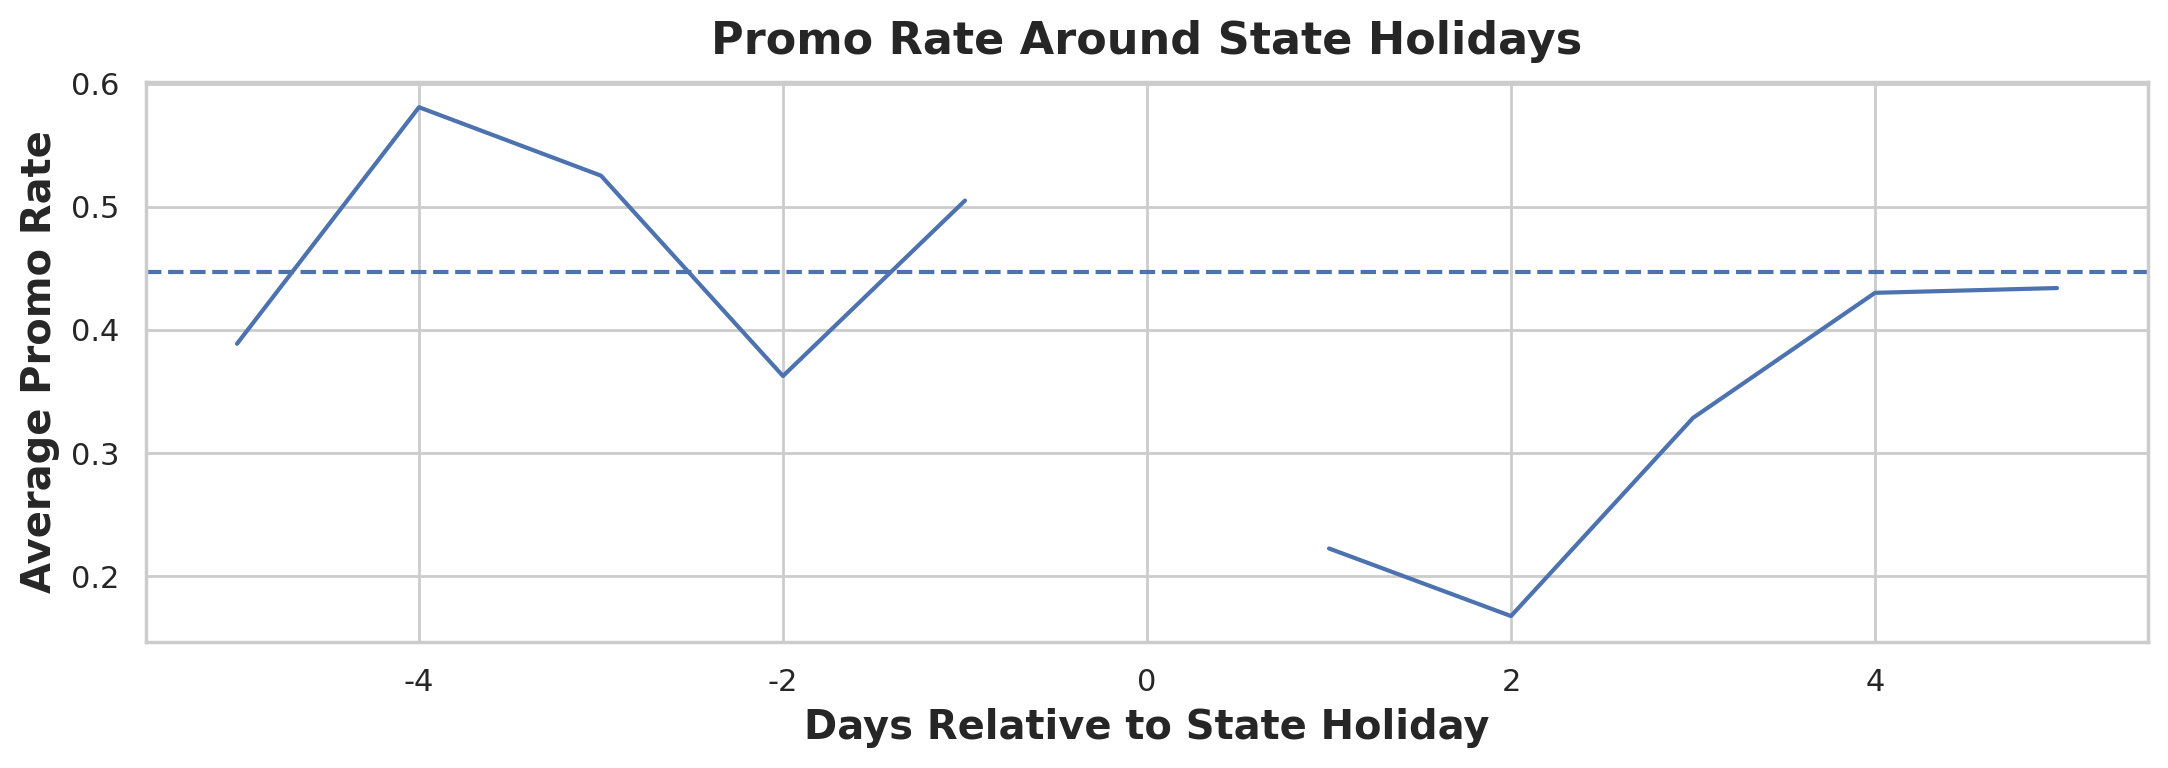

In [ ]:
# 合并回来拿到真实数据行（只保留 open & 非stateholiday 的天）
 = (
    holiday_win.merge(
        split2[['Store','Date','Promo','promo_rate_baseline']],
        left_on=['Store','target_date'],
        right_on=['Store','Date'],
        how='left'holiday_win
    )
)

# promo 相对 baseline 差
holiday_win['promo_uplift'] = holiday_win['Promo'] - holiday_win['promo_rate_baseline']

holiday_win.groupby("rel_day")['Promo'].mean().plot()
plt.axhline(split2['Promo'].mean(), linestyle='--')
plt.title('Promo Rate Around State Holidays')
plt.xlabel('Days Relative to State Holiday')
plt.ylabel('Average Promo Rate')
plt.show()